[UCI Restaurant consummer dataset](https://archive.ics.uci.edu/ml/datasets/Restaurant+%26+consumer+data)

![](uci_site.png)

# lendo os dados e inspecionando os dados

In [1]:
import pandas as pd

In [2]:
users = pd.read_csv("data/userprofile.csv")

In [3]:
users.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


In [4]:
ratings = pd.read_csv("data/rating_final.csv")

In [5]:
ratings.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [6]:
cuisine = pd.read_csv("data/chefmozcuisine.csv")
cuisine.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


# listar a frequencia dos restaurantes, qual vale a pena escolher?

Optamos pelo Mexicano!

In [7]:
cuisine["Rcuisine"].value_counts()[:10]

Mexican             239
International        62
American             59
Dutch-Belgian        55
Italian              42
Greek                33
Bar                  32
French               31
Cafe-Coffee_Shop     27
Pizzeria             25
Name: Rcuisine, dtype: int64

In [8]:
mexican_cuisine = "Mexican"
mexican_cuisine = cuisine.loc[cuisine["Rcuisine"] == mexican_cuisine, "placeID"].values.tolist()

In [9]:
# lista com os IDs dos restaurantes mexicanos:
mexican_cuisine[:10]

[135106,
 135104,
 135102,
 135101,
 135100,
 135097,
 135094,
 135093,
 135092,
 135090]

In [10]:
mexican_ratings = ratings.loc[ratings["placeID"].isin(mexican_cuisine), ]

In [11]:
# ratings dos restaurantes mexicanos
mexican_ratings.head()

,userID,placeID,rating,food_rating,service_rating
2,U1077,132825,2,2,2
4,U1068,135104,1,1,2
5,U1068,132740,0,0,0
6,U1068,132663,1,1,1
7,U1068,132732,0,0,0


# análise exploratória

A melhorar!

In [12]:
import matplotlib.pyplot as plt

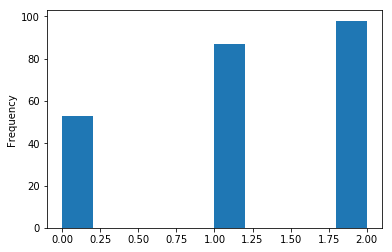

In [13]:
mexican_ratings["rating"].plot(kind="hist")
plt.show();

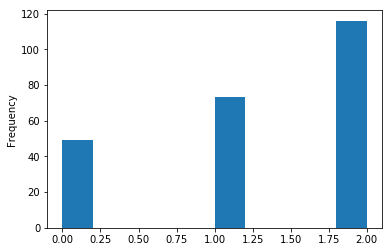

In [14]:
mexican_ratings["food_rating"].plot(kind="hist")
plt.show();

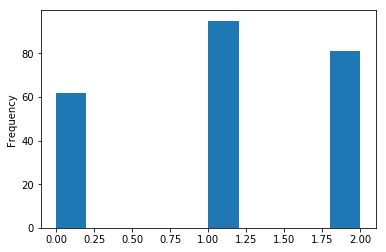

In [15]:
mexican_ratings["service_rating"].plot(kind="hist")
plt.show()

# separando o alvo

In [16]:
target = mexican_ratings.groupby("userID", as_index=False)["rating"].mean()

In [17]:
target.loc[:, "gosta_mexicano"] = 0
target.loc[target["rating"] == 2, "gosta_mexicano"] = 1

In [18]:
target.head()

,userID,rating,gosta_mexicano
0,U1001,2.000000,1
1,U1002,1.333333,0
2,U1003,2.000000,1
3,U1004,2.000000,1
4,U1006,1.000000,0


In [19]:
del target["rating"]

# vetorizando a base de usuários

In [20]:
from utils import vectorize

In [21]:
help(vectorize)

Help on function vectorize in module utils:

vectorize(users)
    Parameters
    ----------
    users: pd.DataFrame
    
    Return
    ------
    users: pd.DataFrame
        A vectorized version of the original pd.DataFrame
        Text columns are turned into number columns



In [22]:
users = vectorize(users)

# separando a base de treino e de teste/produção

In [23]:
train = pd.merge(users, target, how="inner", on="userID")

In [24]:
usuarios_base_treinamento = train["userID"].values.tolist()

In [25]:
test = users.loc[~users["userID"].isin(usuarios_base_treinamento), ]

# separando características e alvo

In [26]:
X_columns = train.columns.tolist()
X_columns.remove("userID")
X_columns.remove("gosta_mexicano")

y_column = "gosta_mexicano"

In [27]:
X = train[X_columns]
y = train[y_column]

X_test = test[X_columns]

In [28]:
# podemos ainda criar uma base de validação
# para termos ideia de performance do modelo
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# treinando o modelo

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
clf = LogisticRegression(solver="lbfgs", max_iter=1000, multi_class="auto", random_state=42)

In [31]:
# a mágica acontece aqui!
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# escorando a base de teste
previsoes_pontuais = clf.predict(X_test)
previsoes_probabilidade = clf.predict_proba(X_test)[:, 1]

users_test = test[["userID"]].copy()
users_test.loc[:, "gosta de mexicano?"] = previsoes_pontuais
users_test.loc[:, "probabilidade de gostar de mexicano?"] = previsoes_probabilidade

users_test.head()

,userID,gosta de mexicano?,probabilidade de gostar de mexicano?
4,U1005,1,0.533907
7,U1008,0,0.213843
9,U1010,0,0.102653
12,U1013,0,0.241826
13,U1014,0,0.060912


# performance

In [33]:
y_pred_valid = clf.predict(X_valid)
y_proba_valid = clf.predict_proba(X_valid)[:, 1]

In [34]:
from utils import plot_roc
from sklearn.metrics import accuracy_score

In [35]:
accuracy_score(y_valid, y_pred_valid)

0.7619047619047619

In [36]:
help(plot_roc)

Help on function plot_roc in module utils:

plot_roc(y_true, y_proba)
    y_true: true values
    y_proba: predicted probabilities



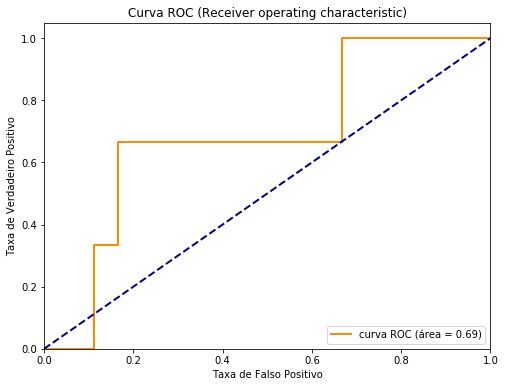

In [37]:
plot_roc(y_valid, y_proba_valid)